In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path as path
import math

In [48]:
def read_datasets():
    file1 = path.cwd().joinpath("OneDrive").joinpath("Desktop").joinpath("Time-Series").joinpath("machine_temp_failure_missing.csv")
    file2 = path.cwd().joinpath("OneDrive").joinpath("Desktop").joinpath("Time-Series").joinpath("machine_temp_failure_original.csv")
    df_miss = pd.read_csv(file1)
    df_orig = pd.read_csv(file2)
#     df_miss.head()
#     df_miss = df_miss.set_index('timestamp')
#     df_orig = df_orig.set_index('timestamp')
    return df_miss, df_orig


In [49]:
def plot_dfs(df,col):
    colors = ['blue' if temp<70.0 else 'red' for temp in df[col]]
    plt.scatter(df['timestamp'],df[col],c=colors)
    plt.xlabel('Time')
    plt.ylabel(col)
    cbar = plt.colorbar()
    cbar.set_label('Temperature Color')
    plt.show()
    
    


In [50]:
def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data

    returns: a list of scores
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores


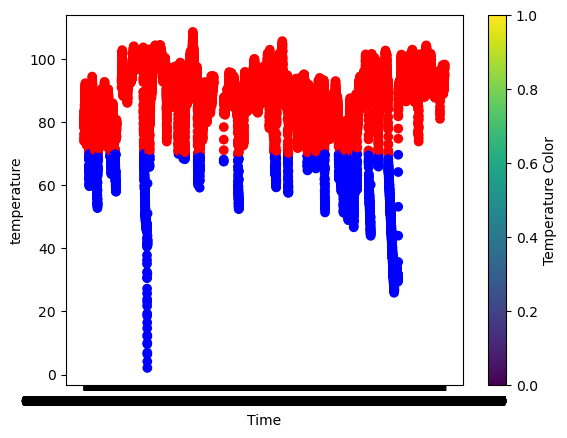

In [51]:
df_miss, df_orig = read_datasets()
df_miss = df_miss.rename({'value':'temperature'},axis=1)
df_orig = df_orig.rename({'value':'temperature'},axis=1)
plot_dfs(df_miss,'temperature')

In [52]:
df_miss['delta_temp'] = df_miss['temperature']
df_miss.head()

,timestamp,temperature,delta_temp
0,02-12-2013 21:15,73.967322,73.967322
1,02-12-2013 21:20,74.935882,74.935882
2,02-12-2013 21:25,76.124162,76.124162
3,02-12-2013 21:30,78.140707,78.140707
4,02-12-2013 21:35,79.329836,79.329836


C:\Users\Hp\AppData\Local\Temp\ipykernel_10696\340030964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_miss['delta_temp'][i]=df_miss['temperature'][i+1]-df_miss['temperature'][i]


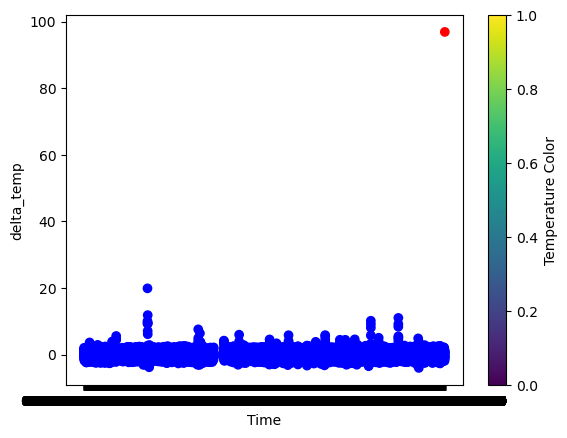

In [53]:
for i in range(len(df_miss.index)-1):
    df_miss['delta_temp'][i]=df_miss['temperature'][i+1]-df_miss['temperature'][i]
plot_dfs(df_miss,'delta_temp')
df_miss['ffill'] = df_miss['temperature'].fillna(method='ffill')
df_miss['bfill'] = df_miss['temperature'].fillna(method='bfill')
df_miss['mean'] = df_miss['temperature'].fillna(df_miss['temperature'].mean())



In [54]:
import hvplot.pandas
df_miss.hvplot(x='timestamp',y='temperature',width=800)


:Curve   [timestamp]   (temperature)

In [55]:
df_miss.hvplot(x='timestamp',y='delta_temp',width=800)

:Curve   [timestamp]   (delta_temp)

In [56]:
from sklearn.impute import SimpleImputer
strategy = [
    ('Mean Strategy', 'mean'),
    ('Median Strategy', 'median'),
    ('Most Frequent Strategy', 'most_frequent')]
temp_vals = df_miss['temperature'].values.reshape(-1,1)
for s_name, s in strategy:
    df_miss[s_name] = (
        SimpleImputer(strategy=s).fit_transform(temp_vals))
    

In [57]:
interpolations = [
    'linear',
    'quadratic',
    'nearest',
    'cubic'
]
import numpy as np
for intp in interpolations:
    df_miss[intp] = df_miss['temperature'].interpolate(method=intp)


In [58]:
_ = rmse_score(df_orig,df_miss,'temperature')

RMSE for delta_temp: 87.03582796006573
RMSE for ffill: 2.4939956524274454
RMSE for bfill: 5.873128567455812
RMSE for mean: 3.961536496226712
RMSE for Mean Strategy: 3.961536496226712
RMSE for Median Strategy: 4.071585793081295
RMSE for Most Frequent Strategy: 20.176855010139285
RMSE for linear: 4.043203597694257
RMSE for quadratic: 11.547623967933964
RMSE for nearest: 4.538509533797259
RMSE for cubic: 12.630605016546783


ffill proves to be the best imputation method

In [59]:
df_miss['timestamp'] = pd.to_datetime(df_miss['timestamp'])
df_miss.set_index('timestamp',inplace=True)
# df_miss.ffill.resample('H').mean()
# df_miss.head()

In [60]:
# df_miss.resample('H').mean()



NameError: name 'loda' is not defined

In [61]:
df_miss.resample('H').mean()

,temperature,delta_temp,ffill,bfill,mean,Mean Strategy,Median Strategy,Most Frequent Strategy,linear,quadratic,nearest,cubic
timestamp,,,,,,,,,,,,
2013-02-12 21:00:00,78.011596,0.613245,78.011596,78.011596,78.011596,78.011596,78.011596,78.011596,78.011596,78.011596,78.011596,78.011596
2013-02-12 22:00:00,80.598012,0.147771,80.598012,80.598012,80.598012,80.598012,80.598012,80.598012,80.598012,80.598012,80.598012,80.598012
2013-02-12 23:00:00,81.625018,0.054031,81.625018,81.625018,81.625018,81.625018,81.625018,81.625018,81.625018,81.625018,81.625018,81.625018
2013-02-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-13 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-02 19:00:00,97.351702,-0.332931,97.351702,97.351702,97.351702,97.351702,97.351702,97.351702,97.351702,97.351702,97.351702,97.351702
2014-12-02 20:00:00,94.759885,0.171144,94.759885,94.759885,94.759885,94.759885,94.759885,94.759885,94.759885,94.759885,94.759885,94.759885
2014-12-02 21:00:00,98.165799,0.019567,98.165799,98.165799,98.165799,98.165799,98.165799,98.165799,98.165799,98.165799,98.165799,98.165799


<Axes: >

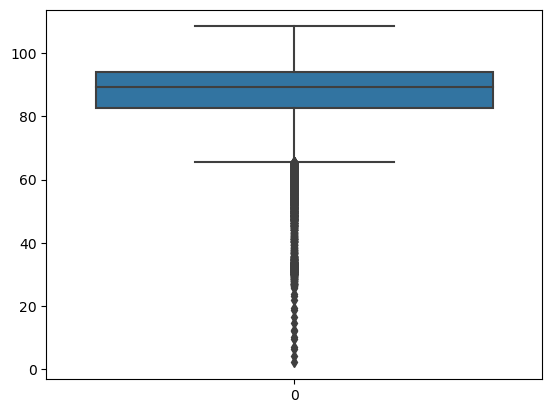

In [62]:
import seaborn as sns
sns.boxplot(df_miss['ffill'])


<Axes: >

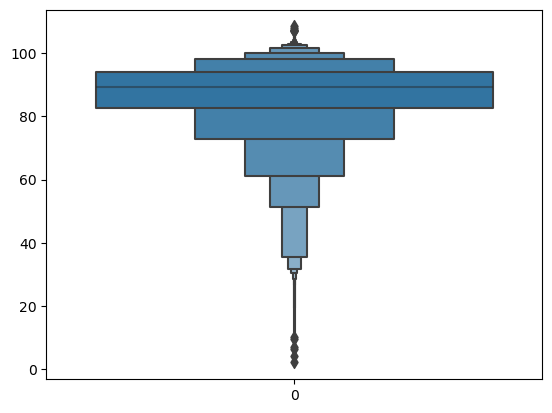

In [63]:
sns.boxenplot(df_miss['ffill'])

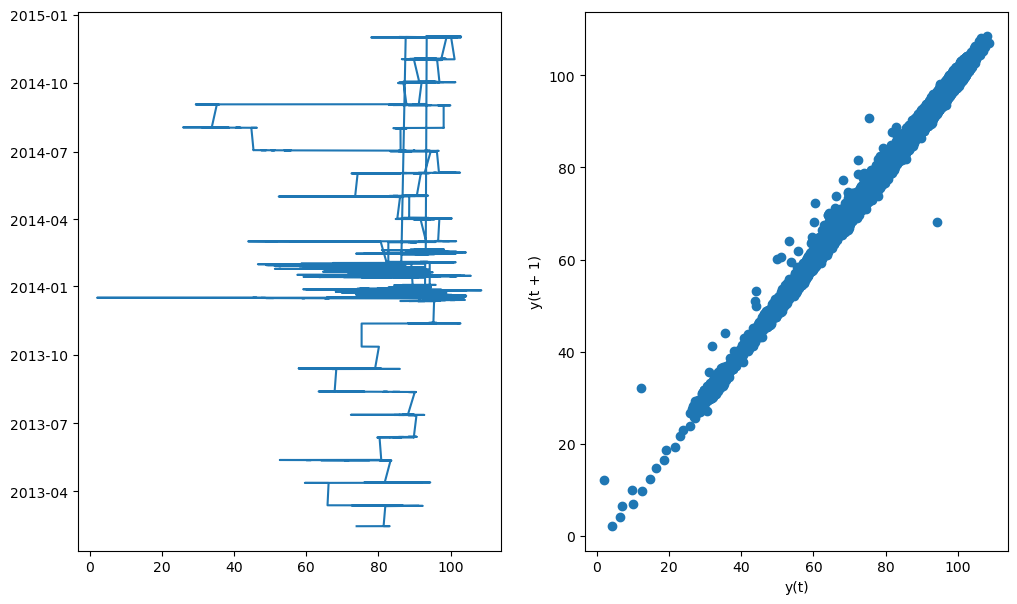

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].plot(df_miss['ffill'], df_miss.index)
pd.plotting.lag_plot(df_miss['ffill'], lag=1,ax=ax[1])
plt.show()

In [68]:
def iqr_outliers(df):
    outliers = []
    for temp in df['ffill']:
        if(temp<50):
            outliers.append(temp)
    return outliers


In [69]:
out = iqr_outliers(df_miss)
print(out)

[49.21029401, 48.84738522, 49.74401138, 49.97094575, 49.33884328, 48.78436052, 49.53339906, 49.78162577, 49.62187665, 49.68919324, 48.30739042, 48.82902834, 48.10254852, 49.46442467, 48.33883452, 48.00434093, 48.90008594, 49.56887872, 49.37605213, 48.80167321, 47.80191086, 49.07504767, 49.24019399, 48.20736299, 48.62104883, 49.51150583, 47.52778085, 49.15285659, 48.22976589, 48.76461254, 48.41482013, 48.5520704, 48.61894249, 47.50916129, 48.65187261, 47.07105491, 47.48283583, 47.15190756, 47.97227843, 47.95899435, 46.96989176, 48.74477405, 47.42435797, 46.61640041, 47.59462942, 48.31961709, 47.22434182, 47.90009631, 48.16424514, 47.60611477, 47.14741295, 47.88889085, 47.25605389, 46.88716102, 46.76427792, 46.26625835, 47.21476764, 47.12237735, 47.84390938, 46.28042599, 47.89438575, 45.88065187, 45.93348708, 46.44069985, 45.69180477, 47.54428761, 45.66502197, 45.78300206, 46.93858357, 46.25313734, 47.62256048, 46.27868176, 46.96455654, 47.48451206, 47.34018048, 46.41420425, 47.49389536,

In [70]:
import scipy.stats as stats


NameError: name 'zscore' is not defined

In [87]:
df_miss['z_scores'] = stats.zscore(df_miss['ffill'])
df_miss['z_scores'].head()

timestamp
2013-02-12 21:15:00   -0.910091
2013-02-12 21:20:00   -0.837610
2013-02-12 21:25:00   -0.748688
2013-02-12 21:30:00   -0.597784
2013-02-12 21:35:00   -0.508798
Name: z_scores, dtype: float64

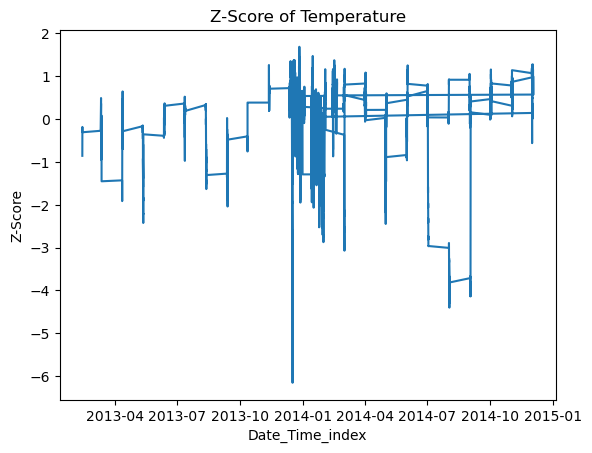

In [86]:
plt.plot(df_miss.index, df_miss['z_scores'])
plt.xlabel('Date_Time_index')
plt.ylabel('Z-Score')
plt.title('Z-Score of Temperature')
plt.show()

1285

0